In [1]:
from qresearch.backtest.buckets import *

In [2]:
from pathlib import Path

# Get current working directory
current_path = Path.cwd() 

# Method 1: Chain .parent
grandparent = current_path.parent.parent

hsci_stocks = pd.read_csv(f'{grandparent}/data/processed/hsci_components.csv')
hsci_stocks.head()

,Date,Stock Code,Stock Name,ISIN,Exchange,Industry,Currency,Closing Price,Daily Change (%)
0,16-01-2026,883,中國海洋石油,HK0883013259,香港交易所,能源業,HKD,21.80,1.80%
1,16-01-2026,857,中國石油股份,CNE1000003W8,香港交易所,能源業,HKD,8.23,0.84%
2,16-01-2026,1088,中國神華,CNE1000002R0,香港交易所,能源業,HKD,40.78,1.12%
3,16-01-2026,386,中國石油化工股份,CNE1000002Q2,香港交易所,能源業,HKD,4.79,0.83%
4,16-01-2026,1171,兗礦能源,CNE1000004Q8,香港交易所,能源業,HKD,10.99,1.20%


In [7]:
import numpy as np
import pandas as pd
import yfinance as yf

START_DATE = "2015-01-01"
END_DATE   = "2026-01-15"

def code_int_to_hk(code: int) -> str:
    return f"{int(code):04d}.HK"

UNIVERSE = hsci_stocks['Stock Code'].apply(code_int_to_hk).tolist()

# price_df = yf.download(UNIVERSE, start=START_DATE, end=END_DATE)
close = pd.read_csv(f'{grandparent}/data/processed/hsci_close.csv', index_col=0)
close.index = pd.to_datetime(close.index)
price_df = close.copy()

hsi = yf.download("^HSI", START_DATE, END_DATE)

# Extract close matrices
# close = price_df["Close"].sort_index()
benchmark_close = hsi["Close"].sort_index()

# Common calendar (optional but recommended)
common_dates = close.index.intersection(benchmark_close.index)
close = close.loc[common_dates]
benchmark_close = benchmark_close.loc[common_dates]

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_83069/4067790574.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  hsi = yf.download("^HSI", START_DATE, END_DATE)
[*********************100%***********************]  1 of 1 completed


In [8]:
# sp500_stocks = pd.read_excel('/Users/henrywzh/Desktop/us_indices.xlsx', sheet_name='sp500')
# sp400_stocks = pd.read_excel('/Users/henrywzh/Desktop/us_indices.xlsx', sheet_name='sp400')

In [9]:
# price_df = yf.download(list(sp400_stocks['Ticker']), start=START_DATE, end=END_DATE)
# ticker = '^GSPC'
# 
# benchmark = yf.download(ticker, start=START_DATE, end=END_DATE)
# benchmark_close = benchmark['Close']

In [10]:
def cs_winsorize_zscore(
    sig: pd.DataFrame,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
) -> pd.DataFrame:
    """
    Cross-sectional winsorize + z-score per date.
    """
    def _proc_row(x: pd.Series) -> pd.Series:
        x = x.astype(float)
        m = x.notna()
        if m.sum() < 5:
            return x  # too few values
        lo = x[m].quantile(lower_q)
        hi = x[m].quantile(upper_q)
        x2 = x.copy()
        x2[m] = x[m].clip(lo, hi)
        mu = x2[m].mean()
        sd = x2[m].std(ddof=1)
        if sd == 0 or not np.isfinite(sd):
            return x2
        x2[m] = (x2[m] - mu) / sd
        return x2

    return sig.apply(_proc_row, axis=1)

def build_ma_signal(price_df, windows=(5, 20, 50, 120)):
    close = price_df["Close"].sort_index()

    ma_sum = 0.0
    for w in windows:
        ma = close.rolling(w, min_periods=w).mean()
        ma_sum += (close / ma - 1.0)

    signal = ma_sum / len(windows)
    return signal

def build_rsi_signal(price_df: pd.DataFrame, period: int = 14) -> pd.DataFrame:
    """
    RSI computed per ticker from Close prices.
    Returns RSI in [0, 100]. Higher RSI = stronger recent gains.
    """
    close = price_df["Close"].sort_index()

    delta = close.diff()
    gain = delta.clip(lower=0.0)
    loss = (-delta).clip(lower=0.0)

    # Wilder's smoothing: EMA with alpha = 1/period
    avg_gain = gain.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi


def build_past_vol_signal(
    price_df: pd.DataFrame,
    window: int = 20,
    use_log_returns: bool = True,
) -> pd.DataFrame:
    """
    Past volatility signal: rolling std of daily returns.
    Output is a DataFrame (dates x tickers) of *past* vol at each date t.

    - If use_log_returns=True: vol of log returns (more stable)
    - window=20: ~1 month
    """
    close = price_df["Close"].sort_index()

    if use_log_returns:
        ret = np.log(close).diff()
    else:
        ret = close.pct_change(fill_method=None)

    vol = ret.rolling(window, min_periods=window).std(ddof=1)
    return vol



vol = build_past_vol_signal(price_df, window=40, use_log_returns=True)
vol_z = cs_winsorize_zscore(vol)

KeyError: 'Close'

In [22]:
n_buckets = 10
H = 5
min_assets_ic = 50

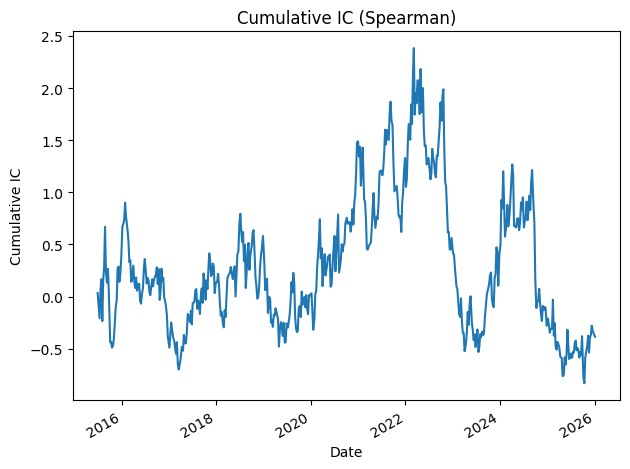

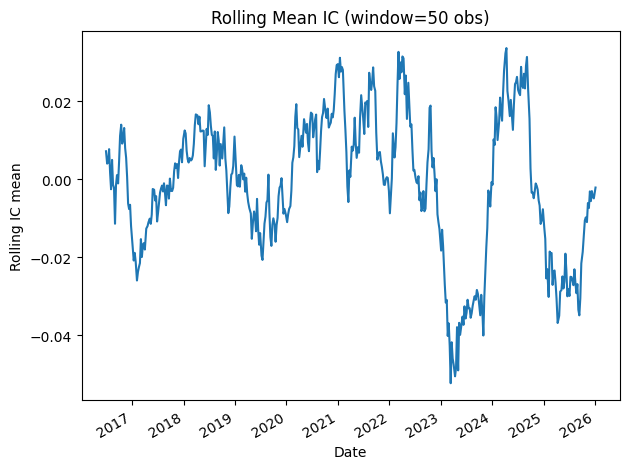

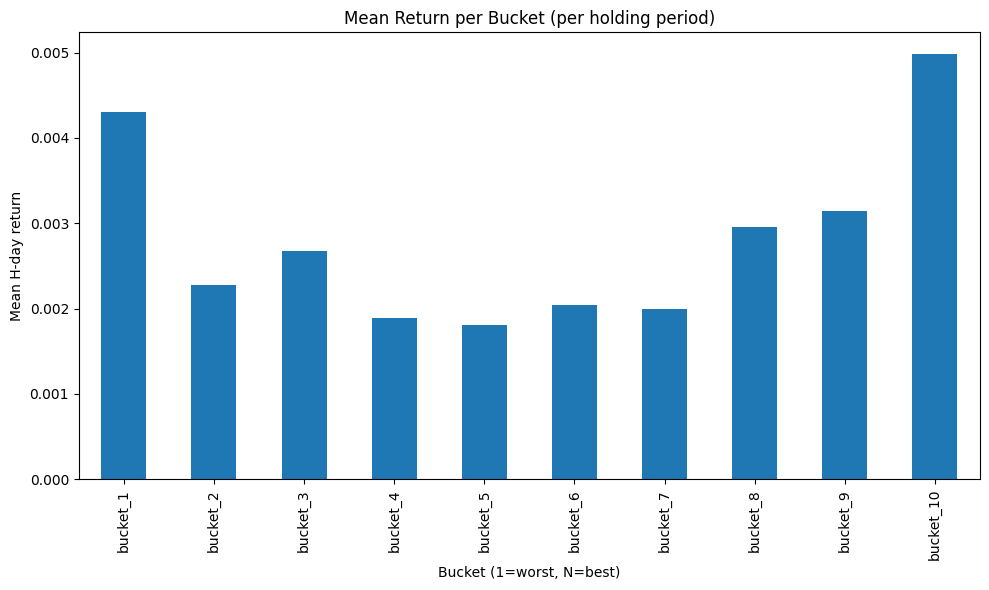

<Figure size 640x480 with 0 Axes>

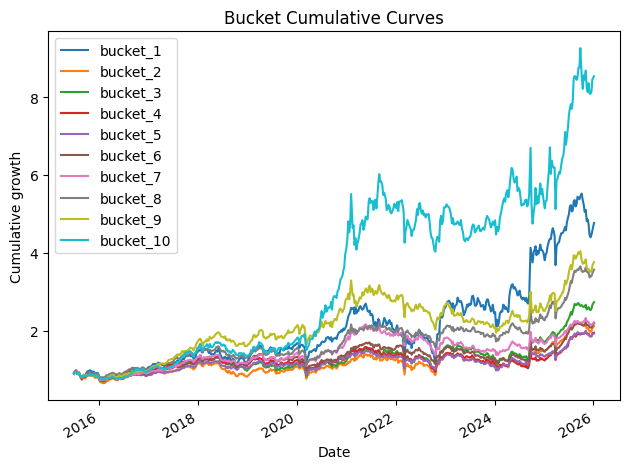

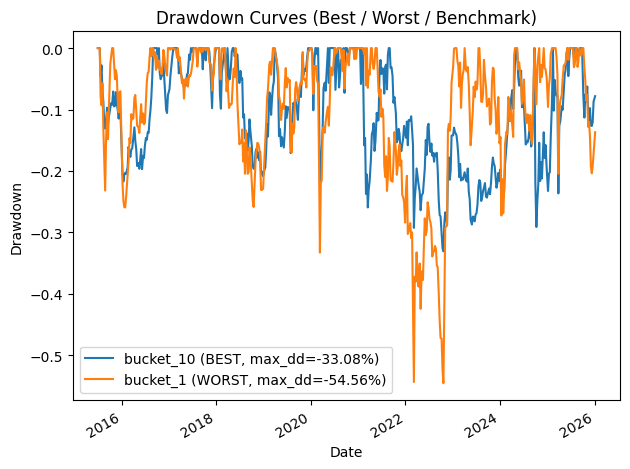

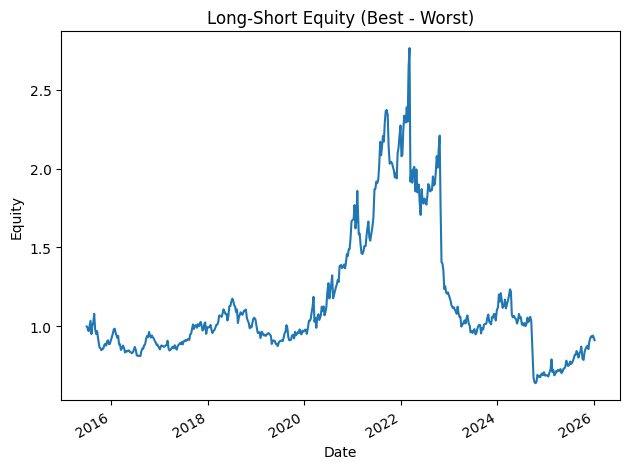

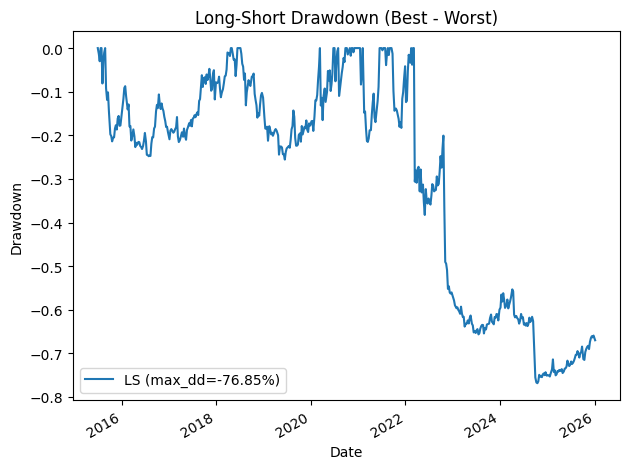

<Figure size 1000x500 with 0 Axes>

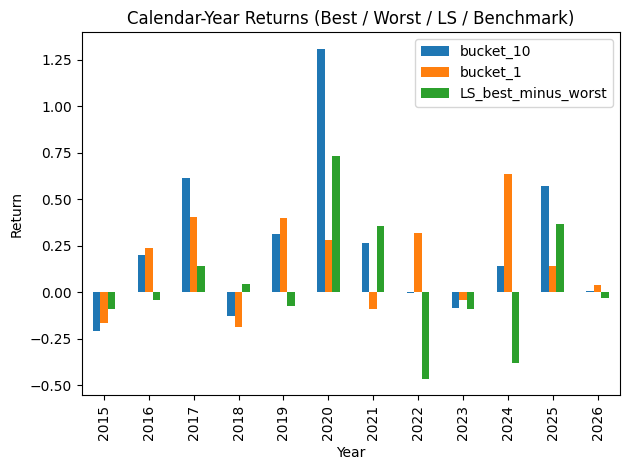

{'ic_mean': -0.0007432857607383595,
 'ic_std': 0.16819954090757616,
 'icir': -0.004419071281215845,
 'hit_rate': 0.5452793834296724,
 'n_obs': 519}

,mean_ret_per_period,std_ret_per_period,t_stat_mean,ann_return_geo,ann_vol,sharpe,max_dd,n_obs
bucket,,,,,,,,
bucket_1,0.004300,0.052012,1.883397,0.163672,0.369245,0.586913,-0.545638,519
bucket_2,0.002276,0.041201,1.258454,0.075340,0.292500,0.392165,-0.387816,519
bucket_3,0.002677,0.039087,1.560466,0.102440,0.277493,0.486279,-0.386742,519
bucket_4,0.001889,0.035023,1.228524,0.066761,0.248640,0.382838,-0.407898,519
bucket_5,0.001811,0.033559,1.229153,0.065467,0.238249,0.383034,-0.339185,519
bucket_6,0.002040,0.033029,1.406900,0.078847,0.234482,0.438424,-0.329022,519
bucket_7,0.001992,0.030460,1.489938,0.080182,0.216245,0.464301,-0.369814,519
bucket_8,0.002959,0.031893,2.113804,0.131383,0.226420,0.658713,-0.321834,519
bucket_9,0.003139,0.034213,2.090321,0.137216,0.242889,0.651395,-0.408297,519


count    519.000000
mean       0.738401
std        0.121642
min        0.555118
25%        0.622047
50%        0.720472
75%        0.844488
max        0.982283
Name: coverage, dtype: float64

In [23]:
signal = build_ma_signal(price_df, windows=(5, 20, 50, 120))

rep = make_tearsheet(
    price_df=price_df,
    signal=signal,
    H=H,
    n_buckets=n_buckets,
    entry_mode="next_close",
    min_assets_ic=min_assets_ic,
    plot=True
)

# Key tables/series:
display(rep["ic_stats"])
display(rep["bucket_summary"])
display(rep["coverage"].describe())


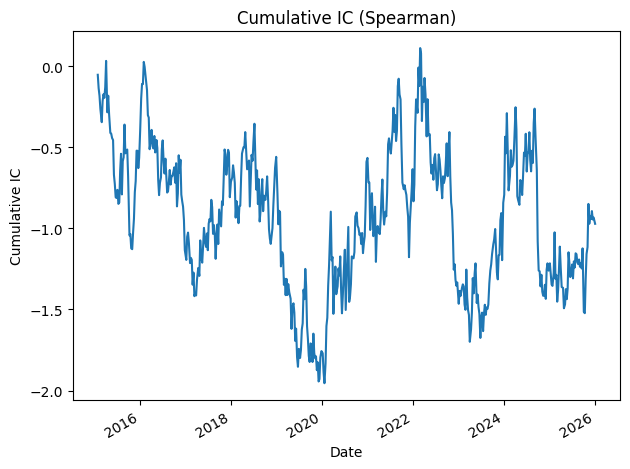

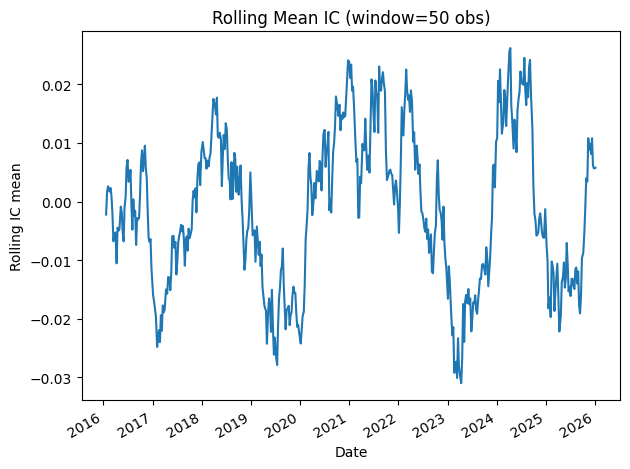

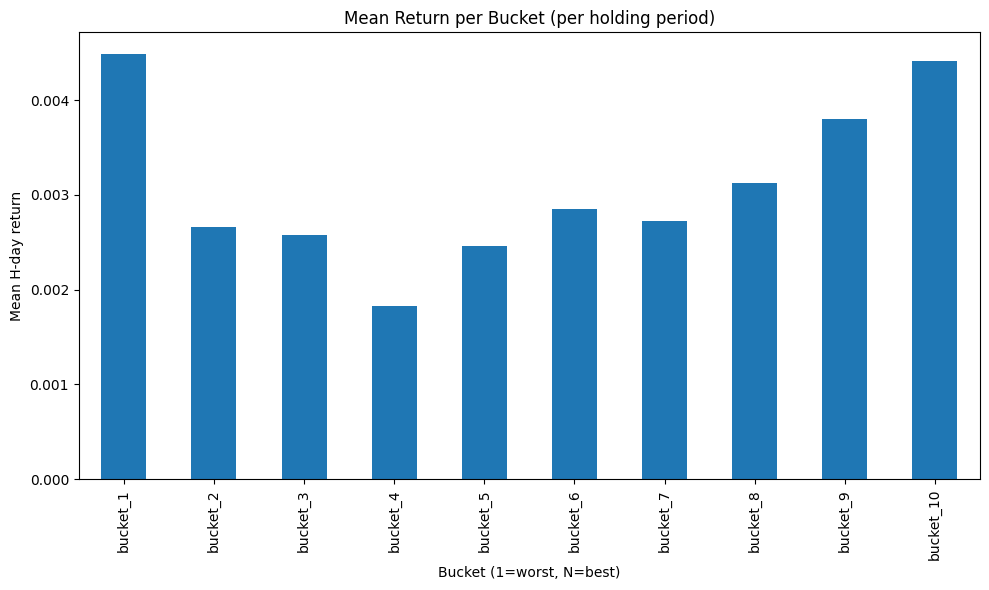

<Figure size 640x480 with 0 Axes>

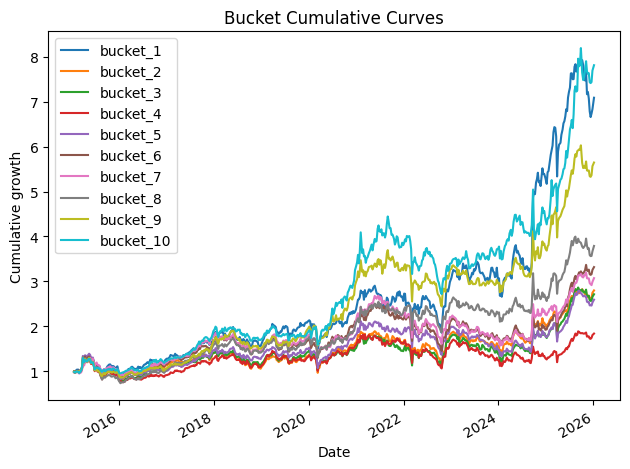

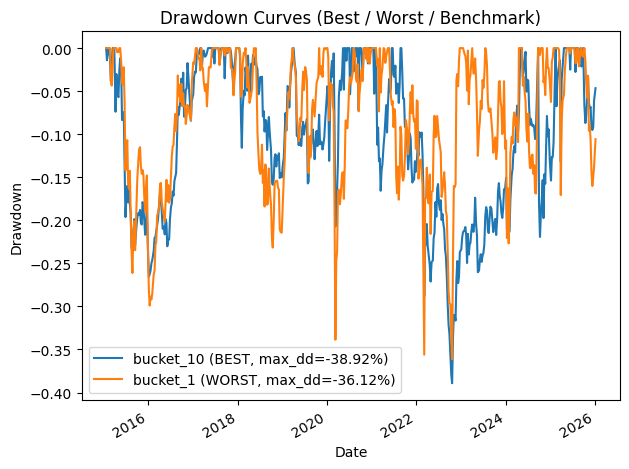

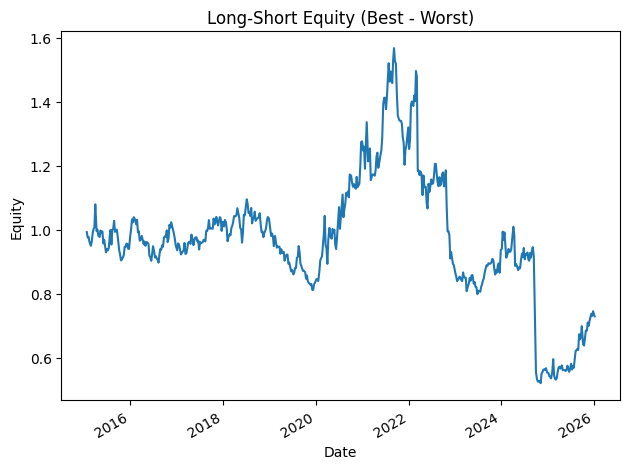

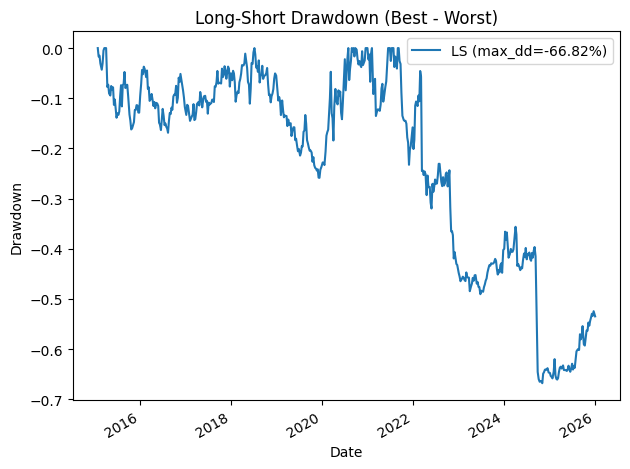

<Figure size 1000x500 with 0 Axes>

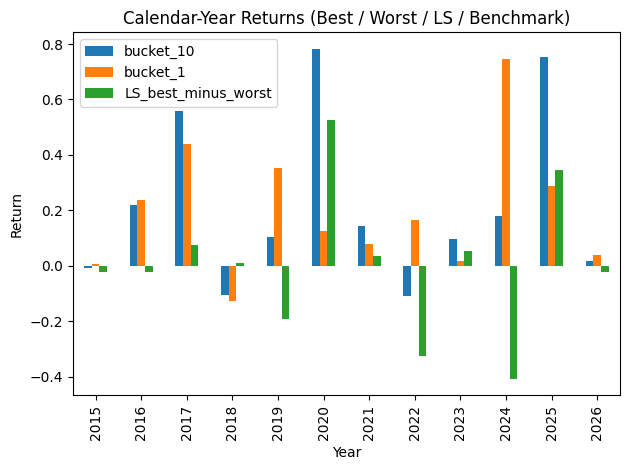

{'ic_mean': -0.0018000386372389395,
 'ic_std': 0.13518593652591843,
 'icir': -0.01331528029836024,
 'hit_rate': 0.5092592592592593,
 'n_obs': 540}

,mean_ret_per_period,std_ret_per_period,t_stat_mean,ann_return_geo,ann_vol,sharpe,max_dd,n_obs
bucket,,,,,,,,
bucket_1,0.004492,0.042446,2.459128,0.200575,0.301338,0.751276,-0.361206,540
bucket_2,0.002662,0.039171,1.579093,0.100777,0.278085,0.482421,-0.415237,540
bucket_3,0.002581,0.038548,1.555764,0.097601,0.273666,0.475294,-0.400879,540
bucket_4,0.001823,0.037547,1.128533,0.058384,0.266556,0.344773,-0.416049,540
bucket_5,0.002464,0.037820,1.513804,0.092961,0.268497,0.462475,-0.406037,540
bucket_6,0.002850,0.035657,1.857633,0.118431,0.253138,0.567516,-0.419089,540
bucket_7,0.002725,0.036522,1.733844,0.110402,0.259278,0.529698,-0.415920,540
bucket_8,0.003123,0.036540,1.985934,0.132367,0.259408,0.606713,-0.444945,540
bucket_9,0.003801,0.034474,2.562093,0.175337,0.244743,0.782732,-0.341815,540


count    540.000000
mean       0.748586
std        0.129378
min        0.553150
25%        0.622047
50%        0.725394
75%        0.860236
max        1.000000
Name: coverage, dtype: float64

In [24]:
rsi = build_rsi_signal(price_df, period=14)
# Hygiene
rsi_z = cs_winsorize_zscore(rsi)

rep_rsi = make_tearsheet(
    price_df=price_df,
    signal=rsi_z,
    H=H,
    n_buckets=n_buckets,
    entry_mode="next_close",   # signal at close[t], enter close[t+1]
    min_assets_ic=min_assets_ic,
    plot=True                  # shows coverage, IC, bucket mean bar, bucket curves, turnover
)

display(rep_rsi["ic_stats"])
display(rep_rsi["bucket_summary"])
display(rep_rsi["coverage"].describe())


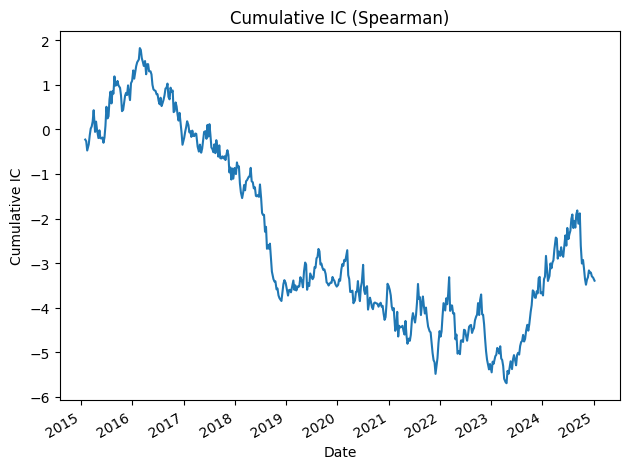

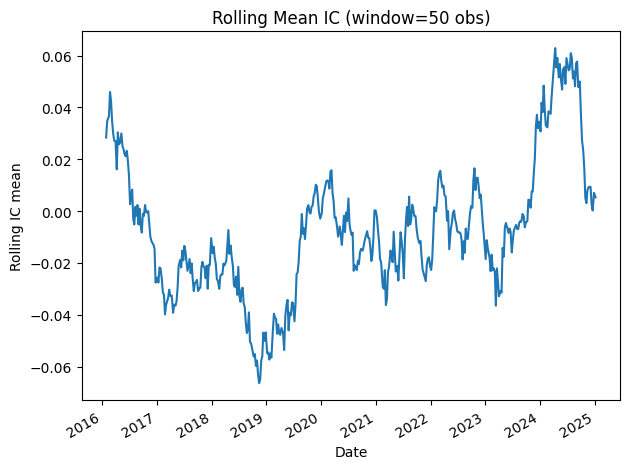

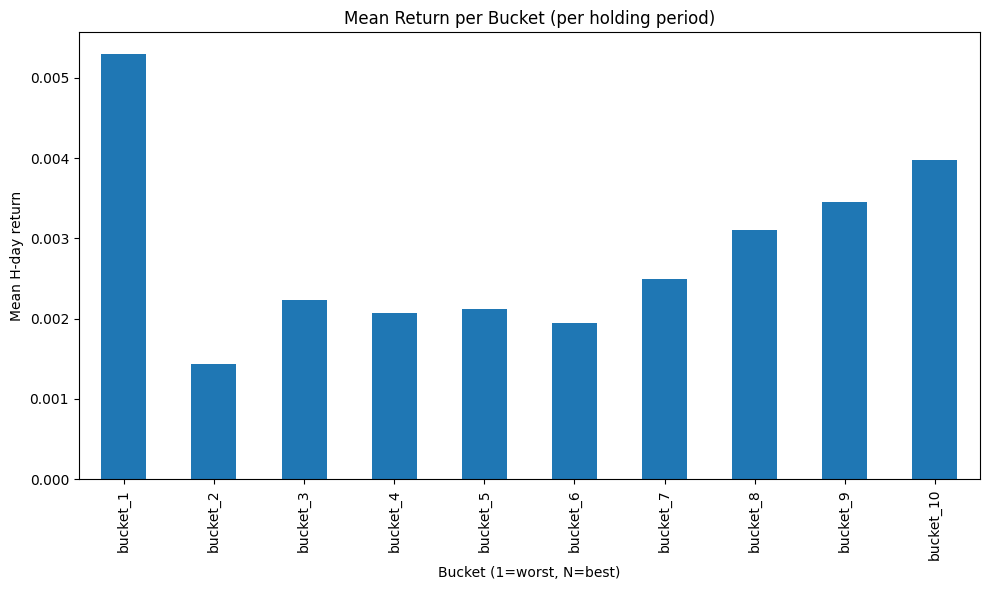

<Figure size 640x480 with 0 Axes>

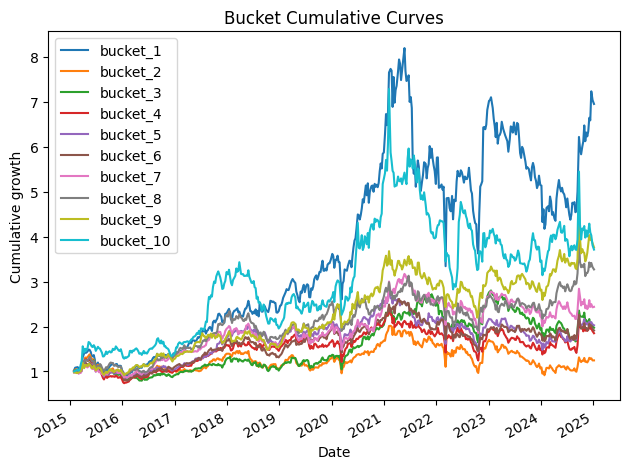

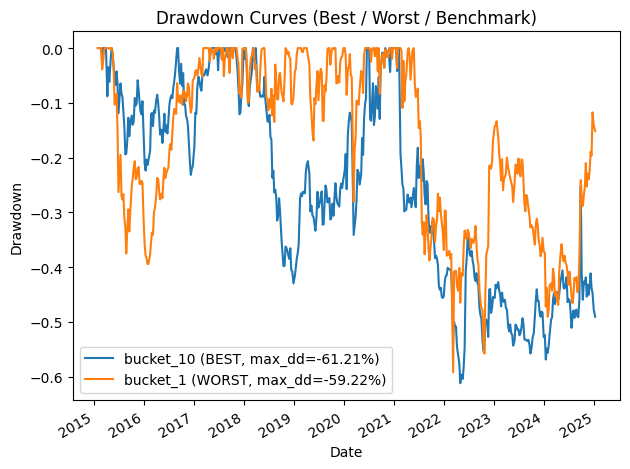

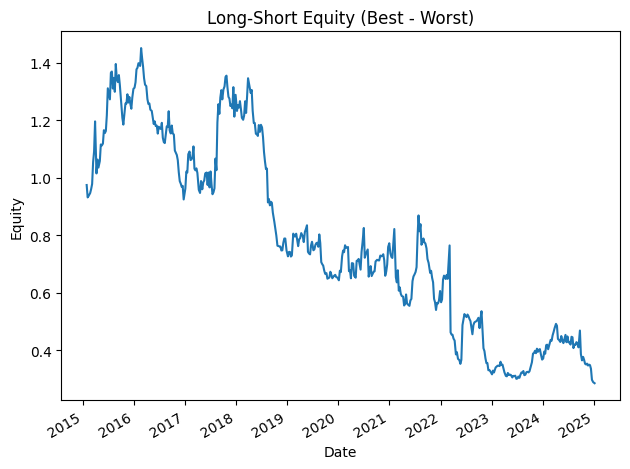

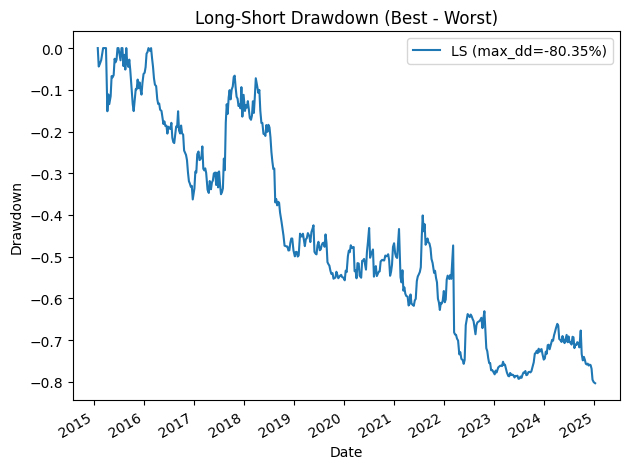

<Figure size 1000x500 with 0 Axes>

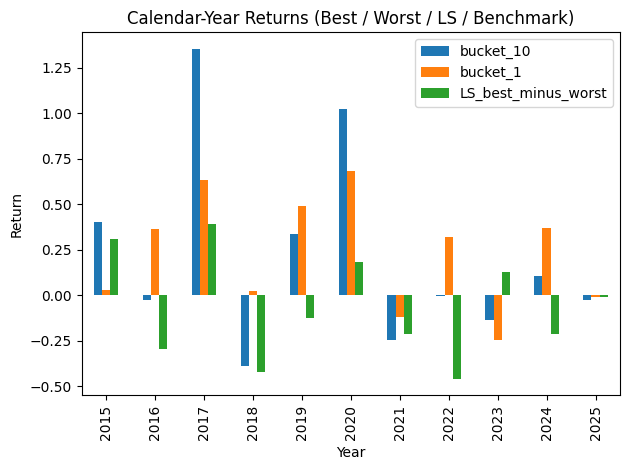

{'ic_mean': -0.006928583448420263,
 'ic_std': 0.1996178680458048,
 'icir': -0.03470923478067812,
 'hit_rate': 0.49795918367346936,
 'n_obs': 490}

,mean_ret_per_period,std_ret_per_period,t_stat_mean,ann_return_geo,ann_vol,sharpe,max_dd,n_obs
bucket,,,,,,,,
bucket_1,0.005301,0.052637,2.229372,0.220769,0.373689,0.714990,-0.592159,490
bucket_2,0.001433,0.044838,0.707643,0.022939,0.318320,0.226951,-0.545737,490
bucket_3,0.002231,0.041577,1.187796,0.072442,0.295165,0.380942,-0.404613,490
bucket_4,0.002076,0.041276,1.113208,0.065392,0.293030,0.357021,-0.491344,490
bucket_5,0.002121,0.037133,1.264357,0.075442,0.263619,0.405496,-0.488963,490
bucket_6,0.001947,0.035355,1.218987,0.068997,0.250992,0.390946,-0.442957,490
bucket_7,0.002499,0.037182,1.487464,0.096000,0.263969,0.477050,-0.414115,490
bucket_8,0.003105,0.037194,1.848156,0.129656,0.264049,0.592728,-0.386478,490
bucket_9,0.003451,0.039139,1.951971,0.145979,0.277856,0.626023,-0.402448,490


count    490.000000
mean       0.843783
std        0.132543
min        0.666667
25%        0.685185
50%        0.861111
75%        0.990741
max        1.000000
Name: coverage, dtype: float64

In [7]:
signal = build_ma_signal(price_df, windows=(5, 20))

rep = make_tearsheet(
    price_df=price_df,
    signal=signal,
    H=H,
    n_buckets=n_buckets,
    entry_mode="next_close",
    min_assets_ic=min_assets_ic,
    plot=True
)

# Key tables/series:
display(rep["ic_stats"])
display(rep["bucket_summary"])
display(rep["coverage"].describe())


In [8]:
bucket_returns = rep['bucket_ret'].copy()
bucket_returns = bucket_returns.merge(benchmark_close.pct_change(), how='inner', left_index=True, right_index=True)
bucket_returns.corr()

,bucket_1,bucket_2,bucket_3,bucket_4,bucket_5,bucket_6,bucket_7,bucket_8,bucket_9,bucket_10,^HSI
bucket_1,1.000000,0.848015,0.847467,0.810957,0.813907,0.770775,0.761190,0.731958,0.670763,0.567477,-0.034434
bucket_2,0.848015,1.000000,0.855248,0.832281,0.820159,0.793137,0.783563,0.720663,0.680746,0.576034,-0.088598
bucket_3,0.847467,0.855248,1.000000,0.846303,0.826829,0.792365,0.783850,0.746903,0.697958,0.570299,-0.062787
bucket_4,0.810957,0.832281,0.846303,1.000000,0.824581,0.812185,0.795739,0.765061,0.730091,0.614096,-0.088031
bucket_5,0.813907,0.820159,0.826829,0.824581,1.000000,0.828217,0.803146,0.787202,0.732921,0.606940,-0.044863
bucket_6,0.770775,0.793137,0.792365,0.812185,0.828217,1.000000,0.829758,0.804306,0.763869,0.653547,-0.036890
bucket_7,0.761190,0.783563,0.783850,0.795739,0.803146,0.829758,1.000000,0.806152,0.773620,0.705108,-0.022188
bucket_8,0.731958,0.720663,0.746903,0.765061,0.787202,0.804306,0.806152,1.000000,0.822358,0.711591,0.004740
bucket_9,0.670763,0.680746,0.697958,0.730091,0.732921,0.763869,0.773620,0.822358,1.000000,0.760064,0.017770
bucket_10,0.567477,0.576034,0.570299,0.614096,0.606940,0.653547,0.705108,0.711591,0.760064,1.000000,-0.006179


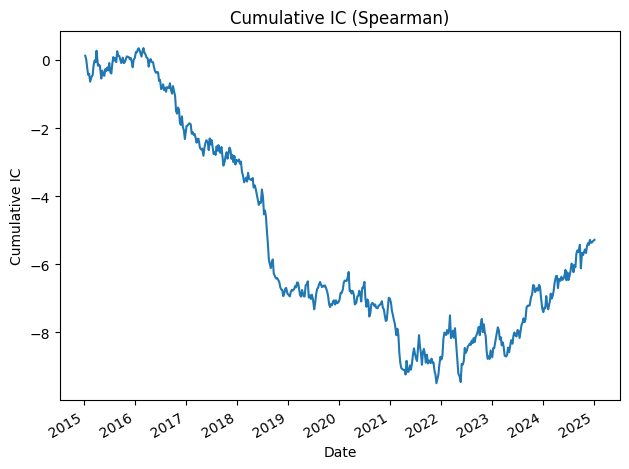

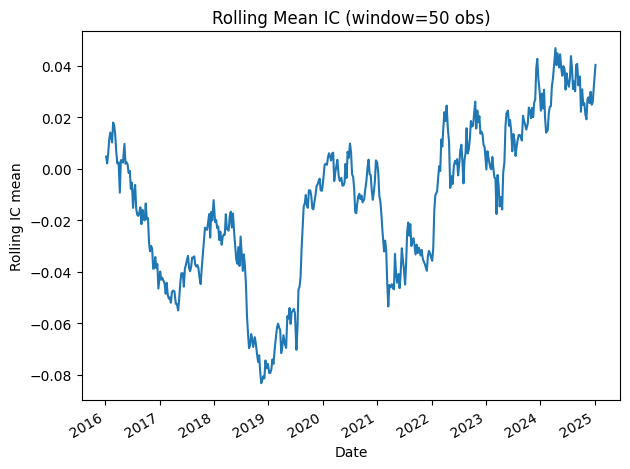

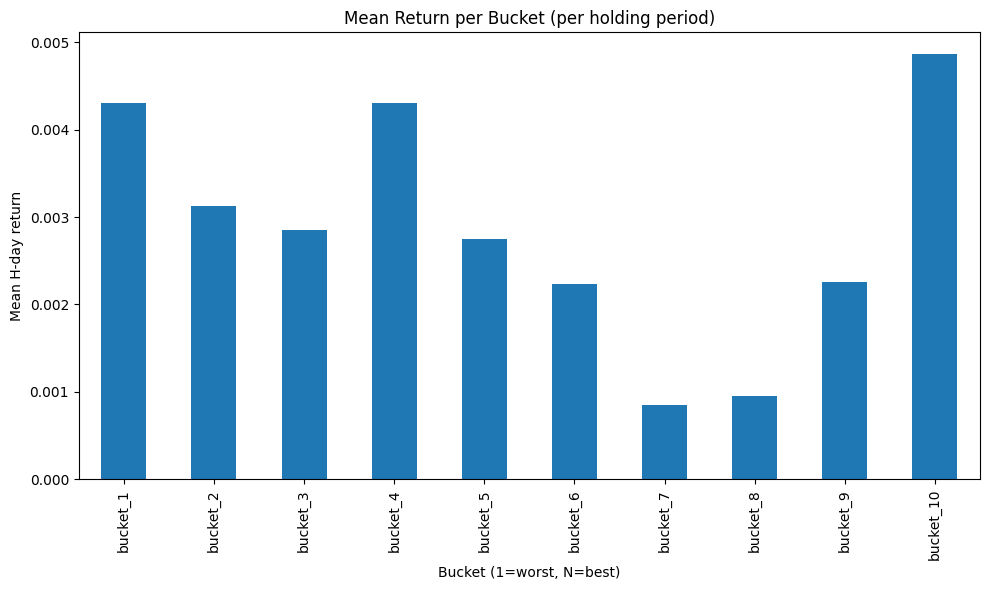

<Figure size 640x480 with 0 Axes>

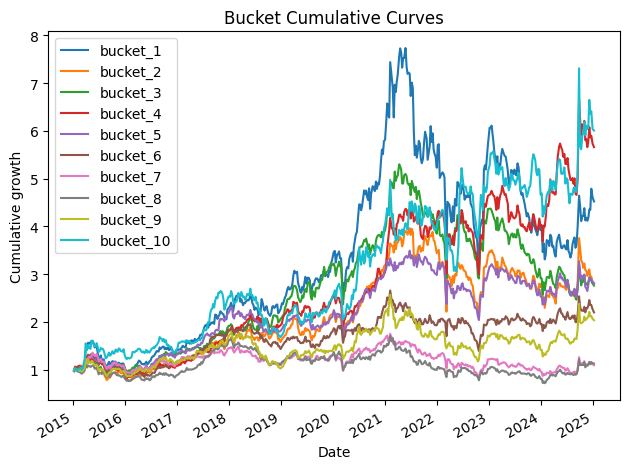

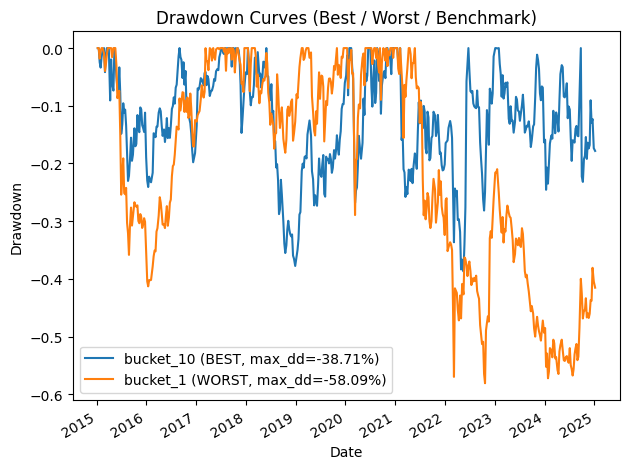

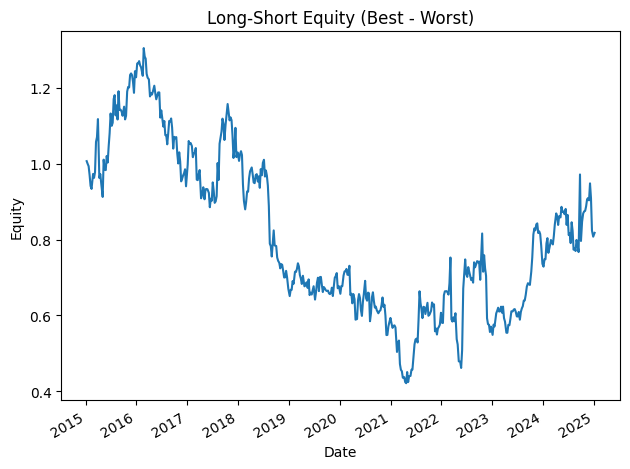

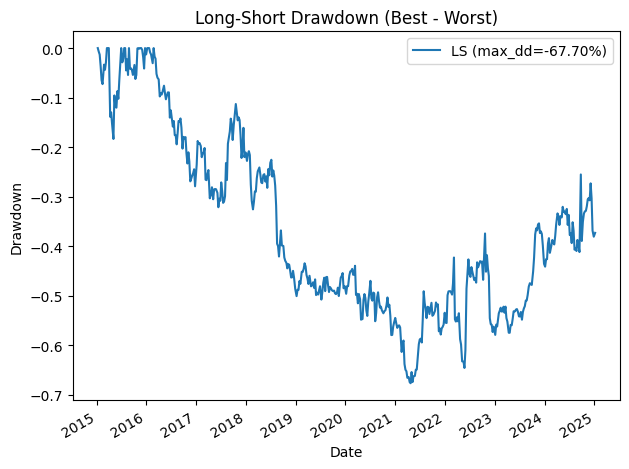

<Figure size 1000x500 with 0 Axes>

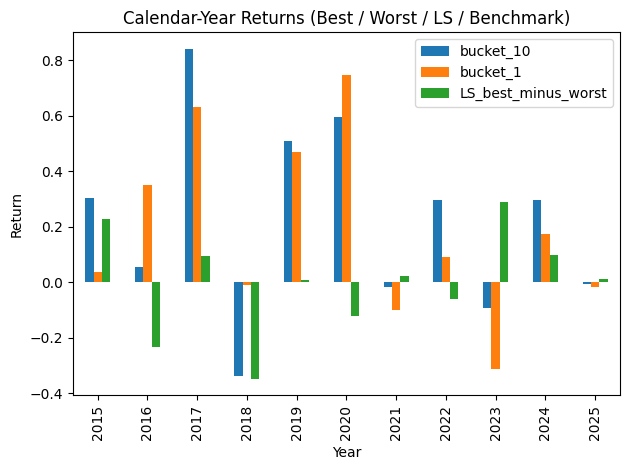

{'ic_mean': -0.010723588746564995,
 'ic_std': 0.19205231585203492,
 'icir': -0.05583681039715706,
 'hit_rate': 0.4827586206896552,
 'n_obs': 493}

,mean_ret_per_period,std_ret_per_period,t_stat_mean,ann_return_geo,ann_vol,sharpe,max_dd,n_obs
bucket,,,,,,,,
bucket_1,0.004307,0.050530,1.892560,0.166789,0.358726,0.605120,-0.580861,493
bucket_2,0.003122,0.046246,1.499076,0.111288,0.328311,0.479309,-0.476050,493
bucket_3,0.002851,0.040323,1.570163,0.109303,0.286262,0.502038,-0.535180,493
bucket_4,0.004306,0.040174,2.380047,0.193860,0.285209,0.760987,-0.348368,493
bucket_5,0.002746,0.036485,1.671037,0.111074,0.259020,0.534291,-0.416137,493
bucket_6,0.002235,0.035858,1.383927,0.083794,0.254568,0.442491,-0.476985,493
bucket_7,0.000844,0.036781,0.509585,0.008953,0.261117,0.162933,-0.517360,493
bucket_8,0.000948,0.037845,0.556483,0.012099,0.268670,0.177928,-0.580650,493
bucket_9,0.002261,0.040859,1.228539,0.075146,0.290070,0.392808,-0.544653,493


count    493.000000
mean       0.844734
std        0.132697
min        0.666667
25%        0.685185
50%        0.861111
75%        0.990741
max        1.000000
Name: coverage, dtype: float64

In [9]:
signal = build_ma_signal(price_df, windows=(5,))

rep = make_tearsheet(
    price_df=price_df,
    signal=signal,
    H=5,
    n_buckets=n_buckets,
    entry_mode="next_close",
    min_assets_ic=min_assets_ic,
    plot=True
)

# Key tables/series:
display(rep["ic_stats"])
display(rep["bucket_summary"])
display(rep["coverage"].describe())


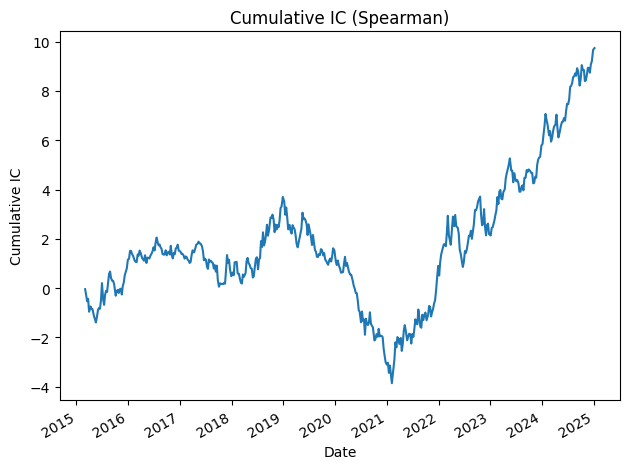

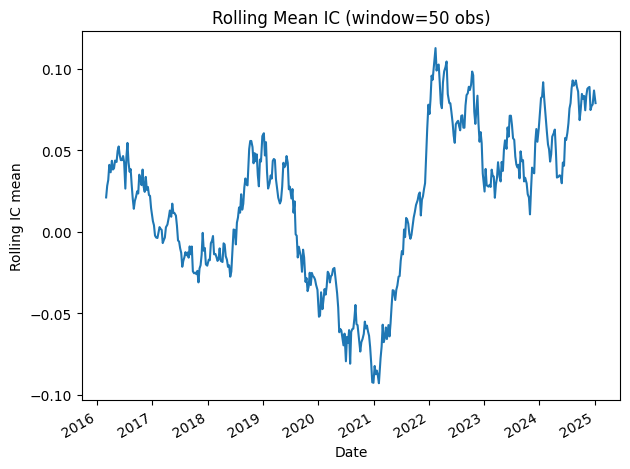

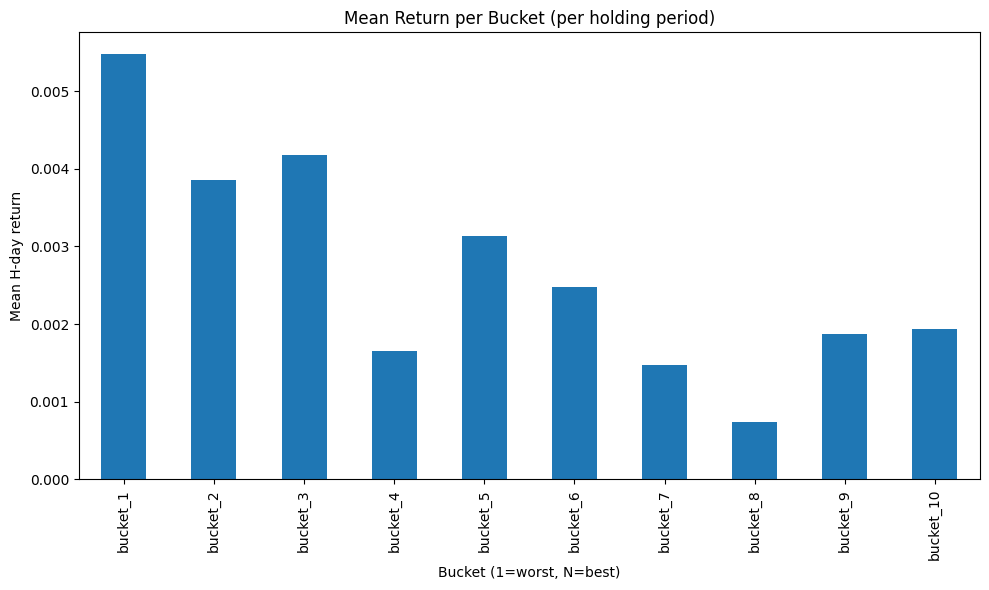

<Figure size 640x480 with 0 Axes>

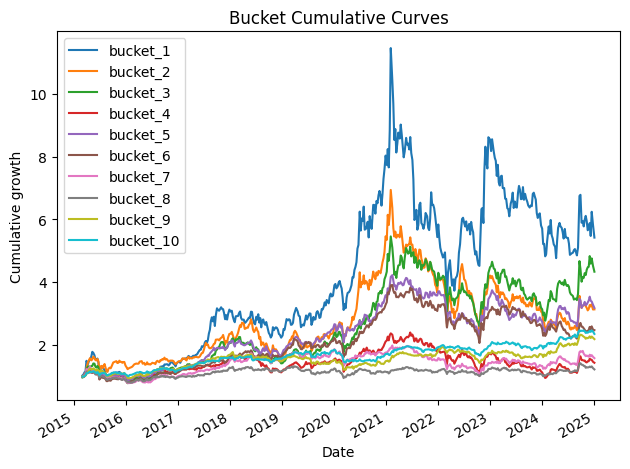

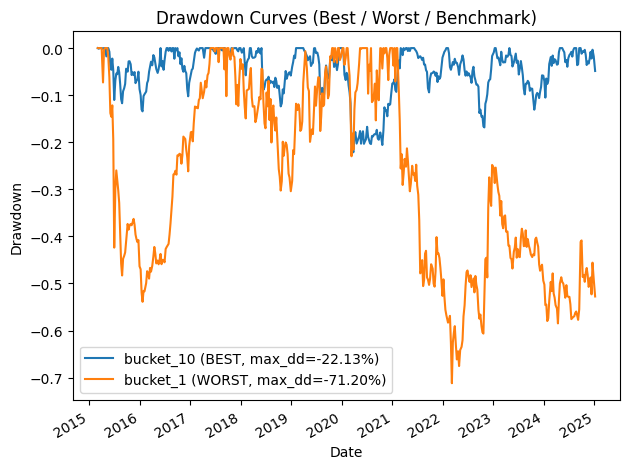

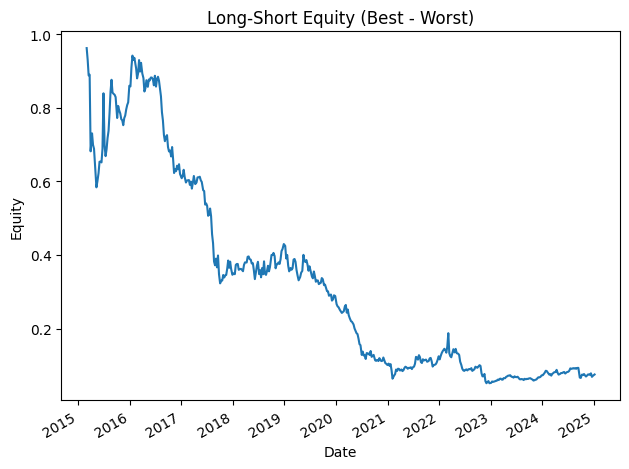

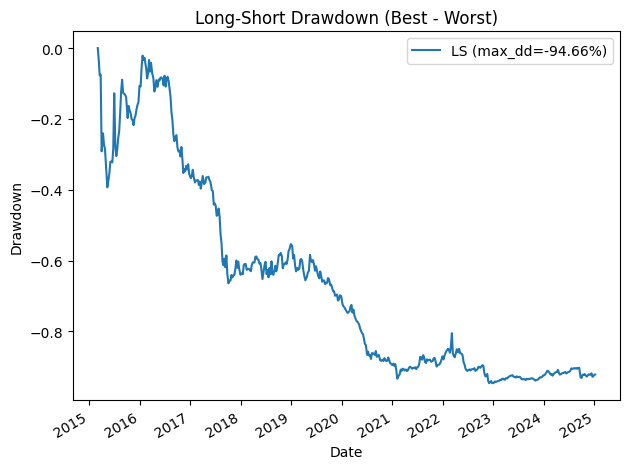

<Figure size 1000x500 with 0 Axes>

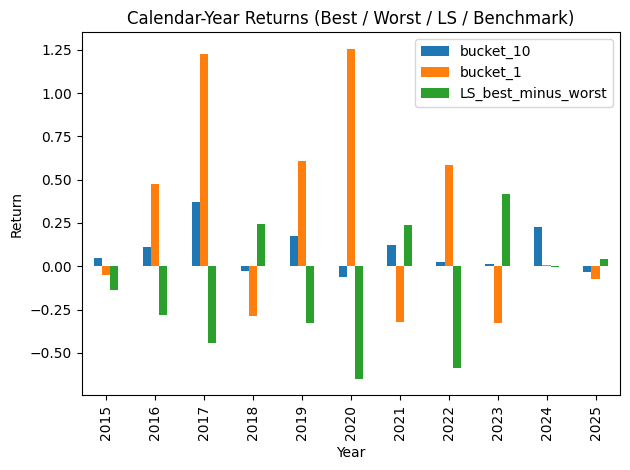

{'ic_mean': 0.020037863833271916, 'ic_std': 0.2838984876176809, 'icir': 0.07058108692800229, 'hit_rate': 0.5041152263374485, 'n_obs': 486}
           mean_ret_per_period  std_ret_per_period  t_stat_mean  \
bucket                                                            
bucket_6              0.002471            0.035167     1.549000   
bucket_7              0.001477            0.033422     0.974404   
bucket_8              0.000737            0.026550     0.612161   
bucket_9              0.001876            0.023575     1.753872   
bucket_10             0.001936            0.019312     2.210095   

           ann_return_geo   ann_vol    sharpe    max_dd  n_obs  
bucket                                                          
bucket_6         0.097810  0.249662  0.498825 -0.474429    486  
bucket_7         0.047589  0.237274  0.313788 -0.495788    486  
bucket_8         0.019603  0.188485  0.197135 -0.318402    486  
bucket_9         0.083791  0.167363  0.564801 -0.321630    486  
b

In [11]:
signal_lowvol = -vol_z  # low vol => high score

rep = make_tearsheet(
    price_df=price_df,
    signal=signal_lowvol,
    H=5,
    n_buckets=n_buckets,
    entry_mode="next_open",
    min_assets_ic=50,
    plot=True
)

print(rep["ic_stats"])
print(rep["bucket_summary"].tail())  # top buckets if monotonic

## Diagnose

In [ ]:
def bucket_constituents(
    bucket_lbl: pd.DataFrame,
    date,
    k: int,
) -> list[str]:
    """
    Returns list of tickers in bucket k on a given date.
    bucket_lbl is typically forward-filled in your backtest.
    """
    d = pd.to_datetime(date)
    if d not in bucket_lbl.index:
        # nearest previous date
        d = bucket_lbl.index[bucket_lbl.index.get_indexer([d], method="ffill")[0]]
    members = bucket_lbl.loc[d]
    return members.index[(members == k).fillna(False)].tolist()

def bucket_snapshot_table(
    bucket_lbl: pd.DataFrame,
    signal: pd.DataFrame,
    ret_fwd: pd.DataFrame,
    date,
    k: int,
    sort_by: str = "signal",
    ascending: bool = False,
) -> pd.DataFrame:
    """
    Creates a table for bucket k on date with:
      - signal[t, i]
      - forward return ret_fwd[t, i] (as used by backtest)
      - bucket id
    """
    d = pd.to_datetime(date)
    if d not in bucket_lbl.index:
        d = bucket_lbl.index[bucket_lbl.index.get_indexer([d], method="ffill")[0]]

    members = bucket_lbl.loc[d]
    tickers = members.index[(members == k).fillna(False)]

    df = pd.DataFrame({
        "bucket": members.loc[tickers].astype(int),
        "signal": signal.loc[d, tickers],
        "ret_fwd": ret_fwd.loc[d, tickers],
    }, index=tickers)

    if sort_by in df.columns:
        df = df.sort_values(sort_by, ascending=ascending)
    return df

def stock_bucket_history(
    bucket_lbl: pd.DataFrame,
    signal: pd.DataFrame,
    ret_fwd: pd.DataFrame,
    ticker: str,
    start=None,
    end=None,
) -> pd.DataFrame:
    s = bucket_lbl[ticker].rename("bucket")
    out = pd.concat([
        s,
        signal[ticker].rename("signal"),
        ret_fwd[ticker].rename("ret_fwd"),
    ], axis=1)

    if start is not None:
        out = out.loc[pd.to_datetime(start):]
    if end is not None:
        out = out.loc[:pd.to_datetime(end)]
    return out

def stock_conditional_performance(
    bucket_lbl: pd.DataFrame,
    ret_fwd: pd.DataFrame,
    ticker: str,
    k: int,
    start=None,
    end=None,
) -> dict:
    s_bucket = bucket_lbl[ticker]
    s_ret = ret_fwd[ticker]

    df = pd.concat([s_bucket.rename("bucket"), s_ret.rename("ret_fwd")], axis=1)
    if start is not None:
        df = df.loc[pd.to_datetime(start):]
    if end is not None:
        df = df.loc[:pd.to_datetime(end)]

    cond = df.loc[df["bucket"] == k, "ret_fwd"].dropna()

    if len(cond) == 0:
        return {"ticker": ticker, "bucket": k, "n": 0, "mean": np.nan, "winrate": np.nan}

    return {
        "ticker": ticker,
        "bucket": k,
        "n": int(cond.shape[0]),
        "mean": float(cond.mean()),
        "winrate": float((cond > 0).mean()),
        "std": float(cond.std(ddof=1)) if cond.shape[0] > 1 else np.nan,
    }

def bucket_membership_frequency(
    bucket_lbl: pd.DataFrame,
    k: int,
    start=None,
    end=None,
) -> pd.Series:
    df = bucket_lbl.copy()
    if start is not None:
        df = df.loc[pd.to_datetime(start):]
    if end is not None:
        df = df.loc[:pd.to_datetime(end)]

    freq = (df == k).sum(axis=0)  # counts of days in bucket k
    freq = freq.sort_values(ascending=False)
    return freq

In [ ]:
bucket_lbl = rep['bucket_labels']
ret_next = rep['ret_fwd']

d = "2023-06-30"
names = bucket_constituents(bucket_lbl, d, k=10)
names

In [ ]:
snap = bucket_snapshot_table(bucket_lbl, signal, ret_next, d, k=1)
snap

In [ ]:
bucket_snapshot_table(bucket_lbl, signal, ret_next, d, k=10)

In [ ]:
signal_lowvol.tail()

In [ ]:
t = rep["bucket_ret"].index[0]  # first rebalance date
lbl_t = rep["bucket_labels"].loc[t]
sig_t = signal_lowvol.loc[t]

# Compare bucket 1 vs bucket 10 signal distributions
b1 = sig_t[lbl_t == 1].dropna()
b10 = sig_t[lbl_t == 10].dropna()

print("bucket1 median signal:", b1.median(), "n=", len(b1))
print("bucket10 median signal:", b10.median(), "n=", len(b10))
